https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_video_display/py_video_display.html

https://www.cs.utexas.edu/~teammco/misc/kalman_filter/

http://bilgin.esme.org/BitsAndBytes/KalmanFilterforDummies


In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [10]:
SENSOR_NOISE = 40

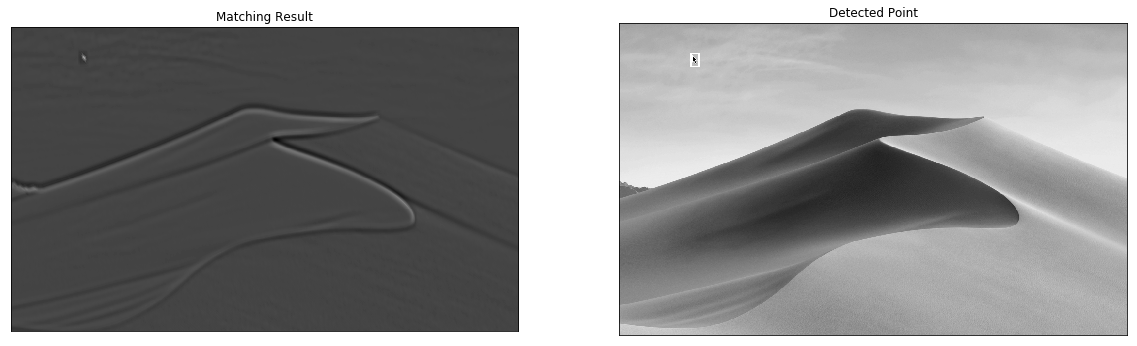

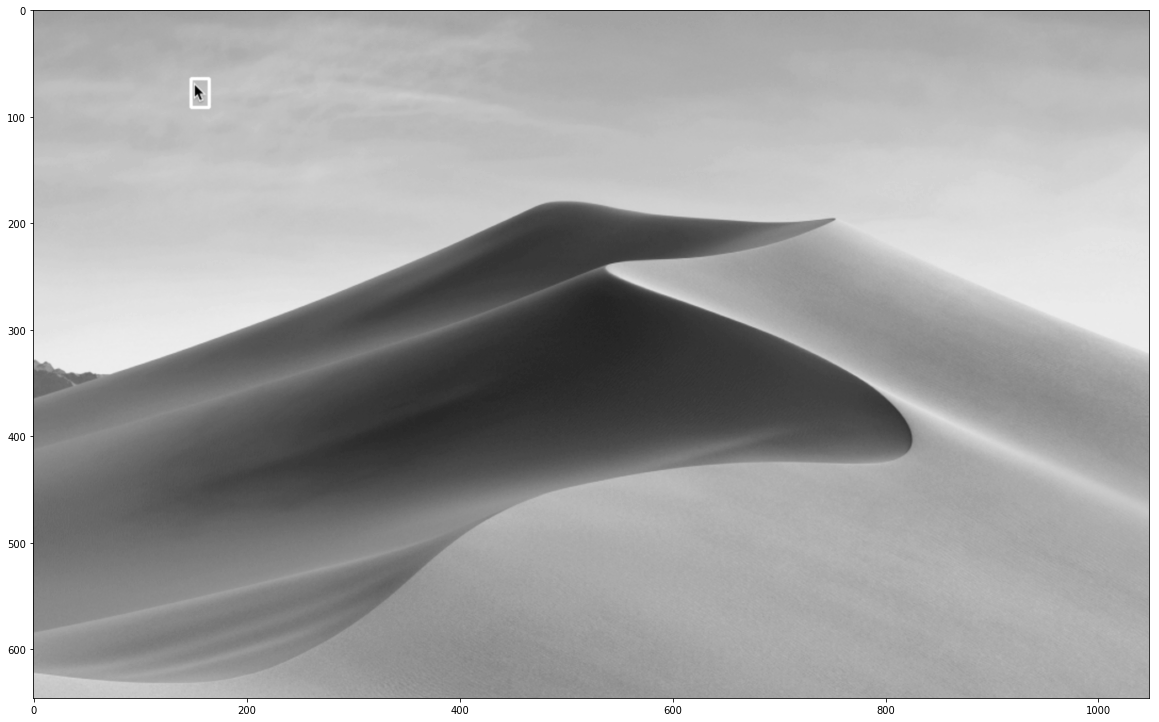

In [11]:
# Test template matching

template = cv2.imread('template.png',0)
frame = cv2.imread('test2.png',0)

img = cv2.resize(frame, None,fx=1/2, fy=1/2, interpolation = cv2.INTER_CUBIC)
template = cv2.resize(template, None,fx=1/2, fy=1/2, interpolation = cv2.INTER_CUBIC)

w, h = template.shape[::-1]

# Apply template Matching
res = cv2.matchTemplate(img, template,cv2.TM_CCOEFF)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)

# true location
cv2.rectangle(img,top_left, bottom_right, 255, 2)

plt.subplot(121),plt.imshow(res,cmap = 'gray')
plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img,cmap = 'gray')
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
plt.show()


plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(img,cmap = 'gray', interpolation = 'bicubic')
plt.show()

In [13]:
cap = cv2.VideoCapture('video1.mov')

template = cv2.imread('template.png',0)
template = cv2.resize(template, None,fx=1/2, fy=1/2, interpolation = cv2.INTER_CUBIC)

w, h = template.shape[::-1]

rect_true_path = []
rect_noise_path = []

while(cap.isOpened()):
    ret, frame = cap.read()
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, None,fx=1/2, fy=1/2, interpolation = cv2.INTER_CUBIC)
    
    # Apply template Matching
    res = cv2.matchTemplate(img,template,cv2.TM_CCOEFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    
    # true location
    rect_true_path.append((top_left, bottom_right))
    for rect in rect_true_path:
        cv2.rectangle(img, rect[0], rect[1], 255, 2)
        
        
    # noice location
    mu, sigma = 0, SENSOR_NOISE
    noise = np.random.normal(mu, sigma,2)
    top_left = np.add(top_left, noise).astype(int)
    bottom_right = np.add(bottom_right, noise).astype(int)
    top_left = (top_left[0], top_left[1])
    bottom_right = (bottom_right[0], bottom_right[1]) 
    
    rect_noise_path.append((top_left, bottom_right))
    for rect in rect_noise_path:
        cv2.rectangle(img, rect[0], rect[1], 150, 2)
    
#     cv2.imshow('frame',img)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

cap.release()
# cv2.destroyAllWindows()

print('Done')

error: OpenCV(4.1.0) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [14]:
# Kalman Filter Matrices

# state transition matrix
A = np.array([
    [1,0,1,0],
    [0,1,0,1],
    [0,0,1,0],
    [0,0,0,1]
])

# control matrix, not used
B = np.eye(4)

# measurement matrix. Position + velocity
H = np.array([
    [1,0,1,0],
    [0,1,0,1],
    [0,0,0,0],
    [0,0,0,0]
])

# action uncertainty matrix. (process noise)
Q = np.array([
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0.1,0],
    [0,0,0,0.1]
])

# sensor noise matrix
R = np.eye(4) * SENSOR_NOISE

control = [0,0,0,0]

In [15]:
# store measurements in convenient form

measurements = []
for i in range(len(rect_noise_path)):
    pos_current = rect_noise_path[i][0]
    pos_prev = rect_noise_path[i-1][0] if i > 0 else pos_current
    
    velocity = np.subtract(pos_current, pos_prev)
    
    measurements.append([pos_current[0], pos_current[1], velocity[0], velocity[1]])

In [16]:
# Kalman Filter: filter noise out

estimation_x = []
estimation_p = []
# set initial values
estimation_x.append([0,0,0,0])
estimation_p.append(np.eye(4))

for i in range(1, len(measurements)):
    # prediction
    X_estimated = A.dot(estimation_x[i-1]) + B.dot(control)
    P = A.dot(estimation_p[i-1].dot(A.T)) + Q
    
    # correction
    S = H.dot(P.dot(H.T)) + R
    K = P.dot(H.T.dot(np.linalg.inv(S)))
    X_measured = measurements[i]
    y = X_measured - (H.dot(X_estimated)) 
    X_predicted = X_estimated + K.dot(y)
    P_predicted = (np.eye(4) - K.dot(H)).dot(P)
    
    # save
    estimation_x.append(X_predicted)
    estimation_p.append(P_predicted)
    
    #print(P)

In [18]:
# draw results: 
# white rectangles - real location
# gray rectangles - measurements with noise
# black rectangles - measurments after Kalman Filter

cap = cv2.VideoCapture('video1.mov')

# store
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc, 20.0, (640,480))

k = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, None,fx=1/2, fy=1/2, interpolation = cv2.INTER_CUBIC)
    
    # true location
    for rect in rect_true_path[0:k]:
        cv2.rectangle(img, rect[0], rect[1], 255, 2)     
        
    # noice location
    for rect in rect_noise_path[0:k]:
        cv2.rectangle(img, rect[0], rect[1], 150, 2)
       
    # after Kalman Filter
    for rect in estimation_x[0:k]:
        top_left = (int(rect[0]), int(rect[1]))
        bottom_right = (top_left[0] + w, top_left[1] + h)
        cv2.rectangle(img, top_left, bottom_right, 10, 2)
        
    k += 1
    
    out.write(img)
    cv2.imshow('frame',img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()

print('DONE')

DONE
